In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
# import os
# import sqlalchemy
# from sqlalchemy import create_engine
import pipeline_plan_functions.utils.pipe_db_handler as dbh
from python_utils.utils.logger import logger
# import alloc_functions.allocation_scenario as asf
import alloc_functions.controller as acf
# import alloc_functions.daily as adf
# import alloc_functions.cleanup as cleaner
# import alloc_functions.mixed as mixed
import alloc_functions.feasibility_functions as ff
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
import matplotlib
# import json
from pulp import *

# import plotly.graph_objects as go
mapbox_token = ('pk.eyJ1Ijoic29mZmZ0IiwiYSI6ImNrbmZ0Z3RidzJ5NngycXA5cDNpY2c1ajIifQ.Gi2oP1Z3G5wP6pn7OF5l1A')

In [2]:
new_sites = (305, 304, 25, 13, 11)

## Telematics

In [14]:
cnx = dbh.create_alch_engine()
sql_query = f"""SELECT departure_time, arrival_time, vehicle_id, distance_miles, departure_site_id, arrival_site_id
    FROM t_telematics WHERE run = 44
    AND departure_site_id IN {new_sites}"""
telematics = pd.read_sql_query(sql_query, con=cnx)
cnx.dispose()

In [17]:
sheet_list = pd.read_csv(
    r'C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\dev\fps_pipeline_plan\functions\shared_functions\telematics\sample\hgv\telematics_check.csv')

In [170]:
site = 13
vehicles_at_site = (2760, 2760, 2220, 2199, 2208, 2834, 2093, 2318, 2234, 2188)
# site = 24
# vehicles_at_site = (8825, 8820, 2282, 2576, 8809, 8812, 8818, 8813, 2513, 2519)
# vehicles_at_site = tuple(sheet_list[sheet_list['site_id'] == site]['vehicle_id'].unique())

cnx = dbh.create_alch_engine()
sql_query = f"""SELECT departure_time, arrival_time, vehicle_id, departure_location,
    arrival_location, departure_site_id, arrival_site_id, route_id
    FROM t_telematics WHERE run = 44
    AND vehicle_id IN {vehicles_at_site}
    order by vehicle_id, departure_time"""
telematics_site = pd.read_sql_query(sql_query, con=cnx)
telematics_site['prev_stay_at_site'] = (telematics_site['departure_time']
                                        - telematics_site['arrival_time'].shift(1)).dt.total_seconds()/3600
mask_change_veh = (telematics_site['vehicle_id'] == telematics_site['vehicle_id'].shift(1))
telematics_site.loc[~mask_change_veh, 'prev_stay_at_site'] = 0
count_locations = telematics_site.groupby('departure_location').agg({
    'departure_time': 'count',
    'vehicle_id': 'nunique',
    'departure_site_id': 'first'
}).sort_values(by='departure_time')
count_locations[count_locations['departure_site_id'] >=0].tail(50)
cnx.dispose()

In [173]:
(telematics_site[telematics_site['departure_site_id'] == site]['prev_stay_at_site'] <1).mean()

0.5454545454545454

In [43]:
site = 24
cnx = dbh.create_alch_engine()
sql_query = f"""SELECT departure_time, arrival_time, vehicle_id, departure_location, departure_site_id, arrival_site_id
    FROM t_telematics WHERE run = 44
    AND departure_site_id = {site}"""
telematics_site = pd.read_sql_query(sql_query, con=cnx)
cnx.dispose()

## Create routes and vehicle duties

### Get routes

In [6]:
cnx = dbh.create_alch_engine()
site_dict = ff.get_site_name_dict(2)
sql_query = f"SELECT * FROM t_route_master WHERE client_id = 3"
routes = pd.read_sql_query(sql_query, con=cnx)
sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2"
vehicle_df = pd.read_sql_query(sql_query, con=cnx, index_col='vehicle_id')
vehicle_spec_dict = vehicle_df['spec_id'].to_dict()
routes['spec_id'] = routes['vehicle_id'].map(vehicle_spec_dict)
good_specs = {100: 'trailers',
              101: '4x2 rigid',
              102: '6x2 rigid',
              103: '4x2 tractor',
              104: '6x2 tractor'}
routes = routes[routes['spec_id'].isin(good_specs.keys())].copy()
# Create vehicle specification table
# connection, cur = dbh.database_connection('test')
specs = tuple(np.arange(101, 111))
vehicle_specifications = ff.find_vehicle_spec(specs)
vehicle_specifications['kwh_mile'] = 0
vehicle_specifications['diesel_l_mile'] = 0
elec_vehicles = vehicle_specifications['fuel_type'] == 'electric'
diesel_vehicles = vehicle_specifications['fuel_type'] == 'diesel'
vehicle_specifications.loc[elec_vehicles, 'kwh_mile'] = vehicle_specifications.loc[elec_vehicles, 'energy_use']
vehicle_specifications.loc[diesel_vehicles, 'diesel_l_mile'] = vehicle_specifications.loc[diesel_vehicles, 'energy_use']

In [7]:
cnx.dispose()

In [4]:
sheet_list = pd.read_csv(r'C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\dev\fps_pipeline_plan\functions\shared_functions\telematics\sample\hgv\telematics_check.csv')
vehicles = sheet_list['vehicle_id'].unique()
vehicle_site_dict = {v: sheet_list[sheet_list['vehicle_id'] == v]['site_id'].values for v in vehicles}
routes['site_ids'] = routes['vehicle_id'].map(vehicle_site_dict)
routes['same_return'] = routes['site_id_start'] == routes['site_id_end']
routes['start_right_id'] = False
routes['duration_hours'] = (routes['arrival_time'] - routes['departure_time']).dt.total_seconds()/3600
routes['date'] = routes['departure_time'].dt.date
routes['start_time'] = (routes['departure_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24
routes['end_time'] = (routes['arrival_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24


# for idx in routes.index:
#     routes.loc[idx, 'start_right_id'] = ff.right_start_site(
#         routes.loc[idx, 'site_id_start'], routes.loc[idx, 'site_ids'])

# for spec in good_specs:
#     spec_routes = routes[routes['spec_id'] == spec]
#     bar_plot_site_ends(spec_routes, site_dict, site, suff=str(spec))

spec_stats = 100*routes.groupby('spec_id')[['same_return']].mean().round(3)
spec_stats['vehicle_type'] = spec_stats.index.map(good_specs)

In [84]:
routes[routes['site_id_start'] == 24].groupby('vehicle_id').count().sort_values(by='client_id').tail(10).index

Int64Index([8825, 8820, 2282, 2576, 8809, 8812, 8818, 8813, 2513, 2519], dtype='int64', name='vehicle_id')

### Mileage stats and route returns

In [6]:
def q75(x):
    return x.quantile(0.75)
def q99(x):
    return x.quantile(0.99)
route_stats = routes.groupby(
    ['site_id_start', 'spec_id']).agg({
        'distance_miles': ['min', 'mean', 'median', q75, q99, 'max'],
        'client_id': 'count',
        'vehicle_id': 'nunique'})
route_stats['site'] = route_stats.index.get_level_values(0).map(site_dict)
route_stats['vehicle_group'] = route_stats.index.get_level_values(1).map(good_specs)
route_stats.columns = ['min', 'mean', 'median', '75%', '99%', 'max', 'n_routes', 'n_vehicles', 'site', 'vehicle_group']
route_stats.sort_values(by=['site', 'vehicle_group'], inplace=True)
route_stats.to_csv('sample/hgv3/site_mileage.csv', index=False)

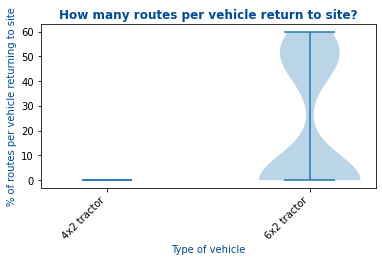

In [204]:
site = 11
site_routes = routes[routes['site_id_start'] == site].set_index('route_id')
vehicle_return_pc = 100*site_routes.groupby(['spec_id', 'vehicle_id'])['same_return'].mean()
vehicle_high_return = vehicle_return_pc > 95
array_return_pc = []
labels = []
for s in [101, 102, 103, 104]:
    if s in vehicle_return_pc.index:
        array_return_pc.append(vehicle_return_pc.loc[s].values)
        labels.append(good_specs[s])
ff.violin_plot(array_return_pc, "routes per vehicle",
               site_dict[site], labels=labels, suff="_routes",
               folder='hgv3')
sample_routes = site_routes[(site_routes['vehicle_id'].isin(vehicles_at_site))].index
# for spec in good_specs:
#     spec_routes = site_routes[(site_routes['spec_id'] == spec)
#                               & (site_routes['site_id_end'] == site)]
    # ff.histo_variable(
    #     spec_routes, 'duration_hours', site_dict[site], upperclip=400,
    #     bins=20, suff=spec, title_text=good_specs[spec])
    # ff.histo_variable(
    #     spec_routes, 'distance_miles', site_dict[site], upperclip=400,
    #     bins=20, suff=spec, title_text=good_specs[spec])

In [200]:
hour_margin = 24
# route = sample_routes[4]
route = np.random.choice(sample_routes)
veh = site_routes.loc[route, 'vehicle_id']
start_dt = site_routes.loc[route, 'departure_time'] - dt.timedelta(hours=hour_margin)
end_dt = site_routes.loc[route, 'arrival_time'] + dt.timedelta(hours=hour_margin)
telematics_route = telematics_site[(telematics_site['vehicle_id'] == veh)
                                   & (telematics_site['departure_time'] >= start_dt)
                                   & (telematics_site['departure_time'] <= end_dt)]
spec = vehicle_df.loc[veh, 'spec_id']
print(route, 'Vehicle', veh, start_dt, '-', end_dt)
telematics_route.to_csv(f'sample/hgv3/sample_route{route}.csv')

1110129 Vehicle 2834 2022-04-24 22:12:57 - 2022-04-26 22:16:26


### Daily duties

In [205]:
duty_wait_time = dt.timedelta(hours=4)
routes.sort_values(by=['vehicle_id', 'departure_time'],
                        inplace=True)
routes['prev_wait_time'] = (routes['departure_time'] - routes['arrival_time'].shift(1))
routes['new_vehicle'] = routes['vehicle_id'] != routes['vehicle_id'].shift(1)
routes['new_duties'] = ((routes['new_vehicle']) | (routes['prev_wait_time'] > duty_wait_time))
routes['duty_id'] = routes['new_duties'].cumsum()

daily_duties = routes.groupby(['duty_id']).agg({
    'departure_time': 'min',
    'site_id_start': ['first', 'nunique'],
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'number_order': 'sum',
    'arrival_time': 'max',
    'route_id': 'count',
    'site_id_end': 'last',
    'spec_id': 'mean',
    'vehicle_id': 'mean',
    'date': 'first',
    'start_time': 'min',
    'end_time': 'max'})
daily_duties.columns = ['departure_time', 'site_id_start', 'number_sites', 'distance_miles',
                        'route_hours', 'number_order', 'arrival_time', 'n_routes', 'site_id_end',
                        'spec_id', 'vehicle_id', 'date', 'start_time', 'end_time']#
daily_duties['same_return'] = daily_duties['site_id_start'] == daily_duties['site_id_end']
daily_duties['duty_duration'] = (daily_duties['arrival_time'] - daily_duties['departure_time']).dt.total_seconds()/3600

duties_selection_dict = {
    'departure_time': 'min',
    'site_id_start': ['first', 'nunique'],
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'arrival_time': 'max',
    'route_id': 'count',
    'site_id_end': 'last',
    'spec_id': 'mean',
    'vehicle_id': 'mean',
    'date': 'first',
    'start_time': 'min',
    'end_time': 'max'}

### Site specific

Site: 11 starting with allocation 820
% duties returning to site: 0.9622641509433962
0.5813953488372093
Start with 107 vehicles showing up in Stoke DC,
       43 have duties starting there
       25 final count


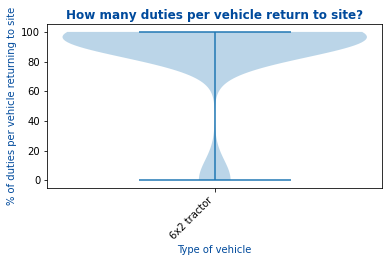

In [208]:
connection, cur = dbh.database_connection('test')
site_list = [11, 13, 24]

site = site_list[0] ## CHECK
# first_alloc_id = acf.get_fps_allocation_id(connection, cur) + 1
first_alloc_id = 820
print(f'Site: {site} starting with allocation {first_alloc_id}')
daily_duties_site = daily_duties[(daily_duties['site_id_start'] == site)
                                 & (daily_duties['spec_id'] > 100)]
spec_stats_duty = 100*daily_duties_site.groupby('spec_id')[['same_return']].mean().round(3)
vehicle_return_duty_pc = daily_duties_site.groupby(['spec_id', 'vehicle_id']).agg({'same_return': 'mean', 'date': 'nunique'})
vehicle_high_return = ((vehicle_return_duty_pc['same_return'] > 0.95)
                       & (vehicle_return_duty_pc['date'] > vehicle_return_duty_pc['date']/3))
array_return_pc = []
labels = []
for s in [101, 102, 103, 104]:
    if s in vehicle_return_duty_pc.index.get_level_values(0).unique():
        array_return_pc.append(100*vehicle_return_duty_pc.loc[s, 'same_return'].values)
        labels.append(good_specs[s])
ff.violin_plot(array_return_pc, "duties per vehicle", site_dict[site],
               labels=labels, suff="_duties",
               folder='hgv3')
print(f"% duties returning to site: {daily_duties_site['same_return'].mean()}")
print(vehicle_high_return.mean())

### Filter vehicle duties and routes

vehicles_to_use = vehicle_high_return[vehicle_high_return].index.get_level_values(1)
duties_site_return = daily_duties[(daily_duties['site_id_start'] == site)
                                #   & (daily_duties['site_id_end'] == site)
                                  & (daily_duties['vehicle_id'].isin(vehicles_to_use))].copy()
# histo_variable(duties_site_return, 'duty_duration', site,
#                 upperclip=400, bins=20, suff=spec, title_text=site)
cols_routes = ['site_id_start', 'departure_time', 'arrival_time',
       'vehicle_id', 'distance_miles', 'route_id', 'site_id_end', 'spec_id',
       'duration_hours', 'date', 'start_time', 'end_time', 'prev_wait_time',
       'new_duties', 'duty_id']
routes_vehicle_selection = routes[routes['vehicle_id'].isin(vehicles_to_use)][cols_routes].copy()
duties_vehicle_selection = daily_duties[daily_duties['vehicle_id'].isin(vehicles_to_use)]
n_vehicles_route_start = routes[routes['site_id_start'] == site]['vehicle_id'].nunique()
n_vehicles_duty_start = daily_duties[daily_duties['site_id_start'] == site]['vehicle_id'].nunique()
n_vehicles_site_final = len(vehicles_to_use)
print(
       f"""Start with {n_vehicles_route_start} vehicles showing up in {site_dict[site]},
       {n_vehicles_duty_start} have duties starting there
       {n_vehicles_site_final} final count"""
)

In [71]:
# This creates new breakpoints in the vehicle duties based on the longest break time back on the site

duty_hour_threshold = 25
duty_hour_min = dt.timedelta(hours=24)
long_duties = duties_vehicle_selection[duties_vehicle_selection['duty_duration'] > duty_hour_threshold].index.values
print(len(long_duties), len(duties_vehicle_selection))
duty_route_cols = ['site_id_start', 'prev_wait_time', 'new_duties', 'departure_time']
for duty in long_duties[:]:
    duty_routes = routes_vehicle_selection[routes_vehicle_selection['duty_id'] == duty][duty_route_cols]
    elapsed_time = duty_routes['departure_time'] - duty_routes['departure_time'].min()
    time_difference = (elapsed_time - duty_hour_min).dt.total_seconds().abs()
    possible_break_routes = ((duty_routes['site_id_start'] == site)
               & (~duty_routes['new_duties']))
    if possible_break_routes.any():
        break_route = time_difference.loc[possible_break_routes].idxmin()
        routes_vehicle_selection.loc[break_route, 'new_duties'] = True

routes_vehicle_selection['duty_id'] = routes_vehicle_selection['new_duties'].cumsum()

duties_vehicle_selection = routes_vehicle_selection.groupby(['duty_id']).agg(duties_selection_dict)

duties_vehicle_selection.columns = ['departure_time', 'site_id_start', 'number_sites', 'distance_miles',
                        'route_hours', 'arrival_time', 'n_routes', 'site_id_end',
                        'spec_id', 'vehicle_id', 'date', 'start_time', 'end_time']

duties_vehicle_selection['duty_duration'] = (duties_vehicle_selection['arrival_time'] - duties_vehicle_selection['departure_time']).dt.total_seconds()/3600
long_duties = duties_vehicle_selection[duties_vehicle_selection['duty_duration'] > duty_hour_threshold].index.values
print(len(long_duties), len(duties_vehicle_selection))

duties_vehicle_selection['same_return'] = duties_vehicle_selection['site_id_start'] == duties_vehicle_selection['site_id_end']
daily_duties_site = duties_vehicle_selection[
    (duties_vehicle_selection['site_id_start'] == site)
    & (duties_vehicle_selection['site_id_end'] == site)
    & (duties_vehicle_selection['spec_id'] > 100)]

0 1854
0 1854


## Histos

In [26]:
site = 24
# Get the vehicles that operate out of the site
cnx = dbh.create_alch_engine()
sql_query = f"""SELECT distinct(vehicle_id)
    FROM t_telematics WHERE run = 44
    AND departure_site_id = {site}"""
telematics = pd.read_sql_query(sql_query, con=cnx)
cnx.dispose()
vehicles_site = tuple(telematics['vehicle_id'].values)
# Get telematic for the vehicles that operate out of the site
sql_query = f"""SELECT departure_time, arrival_time, departure_site_id, arrival_site_id, vehicle_id, route_id
    FROM t_telematics WHERE run = 44
    AND vehicle_id IN {vehicles_site}"""
telematics = pd.read_sql_query(sql_query, con=cnx)
telematics.sort_values(by=['vehicle_id', 'departure_time'], inplace=True)
cnx.dispose()
# Calculate depot dwell time
telematics['prev_stay_at_site'] = (telematics['departure_time']
                                   - telematics['arrival_time'].shift(1)).dt.total_seconds()/3600
mask_same_veh = (telematics['vehicle_id'] == telematics['vehicle_id'].shift(1))
telematics = telematics[mask_same_veh]
# Filter dwell time on site
telematics_site = telematics[telematics['departure_site_id'] == site]

telematics_site = telematics_site.merge(vehicle_df[['spec_id', 'refrigerated']], how='left',
                 left_on='vehicle_id', right_index=True)

In [27]:
FPS_COLOURS = ['#004A9C', '#45D281', '#FEC001', '#A365E0', '#5B9BD5',
               '#FF0000', '#0563C1', '#954F72']
def histo_variable(df, colname, site_name, upperclip=None,
                   lowerclip=None, bins=10, folder="-",
                   suff='', vline_dict=None, title_text=None,
                   plot_mean=True, cumdist=False, xlabel=None):
    fig, ax = plt.subplots(
        1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
    if title_text is None:
        title_text = site_name
    ax.set_title(
        f'{title_text}',
        color=FPS_COLOURS[0], fontweight='bold')
    r = ax.hist(
        df[colname].clip(upper=upperclip, lower=lowerclip),
        color=[FPS_COLOURS[0]],
        bins=bins, cumulative=cumdist, density=cumdist)
    if xlabel is None:
        xlabel = colname
    ax.set_ylabel('# of routes', color=FPS_COLOURS[0])
    ax.set_xlabel(f'{xlabel}', color=FPS_COLOURS[0])
    # ax.text(x=r[1][-1]*1.1, y=r[0].max()/2, s=(
    #     f"{len(df)} entries\n"
    #     f"Mean: {np.round(df[colname].mean(), 1)}\n"
    #     f"Max: {np.round(df[colname].max(), 1)}\n"
    #     f"Median: {np.round(df[colname].median(), 1)}\n"
    #     f"{np.round((df[colname] > upperclip).mean()*100, 1)}% "
    #     f"over threshold {upperclip}\n"
    #     f"{np.round((df[colname] < lowerclip).mean()*100, 1)}% "
    #     f"under threshold {lowerclip}"
    #     ))
    if vline_dict:
        for i, key in enumerate(vline_dict.keys()):
            ax.axvline(x=vline_dict[key], label=key,
                       color=FPS_COLOURS[(i+1) % len(FPS_COLOURS)])
        ax.legend(frameon=False, bbox_to_anchor=(1, 0), loc='lower left')
    if plot_mean:
        ax.axvline(x=df[colname].mean(),
                   color='black', ls='--',
                   label=f"Mean: {np.round(df[colname].mean(), 1)}")
        ax.legend(frameon=False, bbox_to_anchor=(1, 0), loc='lower left')
    fig.savefig(
        f"sample/{folder}/{site_name}_histo_{colname}{suff}.jpg",
        bbox_inches="tight", dpi=300)
    return

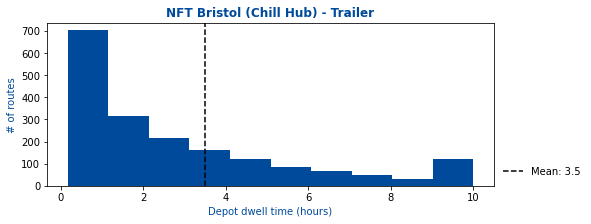

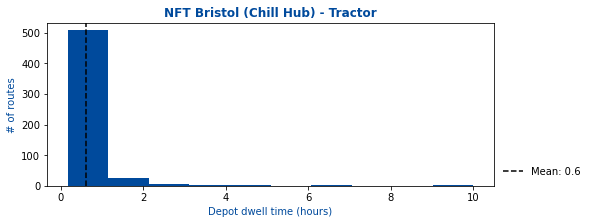

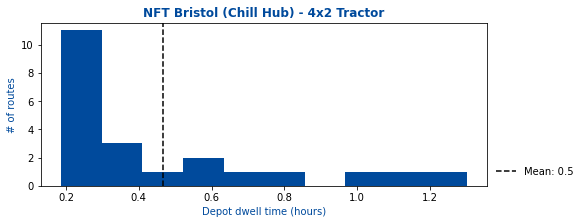

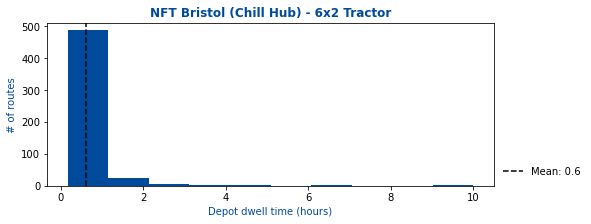

In [28]:
# Filter tractor/refrigerated trailers
category = 'Trailer'
# category = 'Tractor'
# category = '4x2 Tractor'
# category = '6x2 Tractor'
mask = {
    'Trailer': ((telematics_site['spec_id'].isin((100, 115, 116, 117)))
                & (telematics_site['refrigerated'])),
    'Tractor': telematics_site['spec_id'].isin((103, 104)),
    '4x2 Tractor': telematics_site['spec_id'] == 103,
    '6x2 Tractor': telematics_site['spec_id'] == 104,
}
for category in ['Trailer', 'Tractor', '4x2 Tractor', '6x2 Tractor']:
    filtered_telematics = telematics_site[mask[category]]
    # Histo of dwell time
    histo_variable(filtered_telematics, 'prev_stay_at_site', site_dict[site], upperclip=10,
                    lowerclip=None, bins=10, folder="hgv3",
                    suff=category, vline_dict=None,
                    title_text=f"{site_dict[site]} - {category}",
                    plot_mean=True, cumdist=False, xlabel='Depot dwell time (hours)')